In [1]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import fast_dsift, no_op, dsift, hog, sparse_hog, igo
from menpo.landmark import labeller, ibug_face_66, ibug_face_49
from menpo.visualize import visualize_images

from menpofit.fitter import noisy_shape_from_shape
from menpofit.sdm import SupervisedDescentFitter, Newton, GaussNewton
from menpofit.visualize import visualize_fitting_result, plot_ced

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Load training data

In [2]:
training_images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=None, normalise=None):
    i = i.crop_to_landmarks_proportion(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    i.pixels = i.pixels.astype(uint8)
    labeller(i, 'PTS', ibug_face_66)
    training_images.append(i)
    
for i in mio.import_images('/vol/atlas/databases/helen/trainset/', 
                           verbose=True, max_images=None, normalise=None):
    i = i.crop_to_landmarks_proportion(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    i.pixels = i.pixels.astype(uint8)
    labeller(i, 'PTS', ibug_face_49)
    training_images.append(i)

Importing assets: [==========] 100% (811/811) - 00:00:00 remaining
Importing assets: [==========] 100% (2000/2000) - 00:00:00 remaining


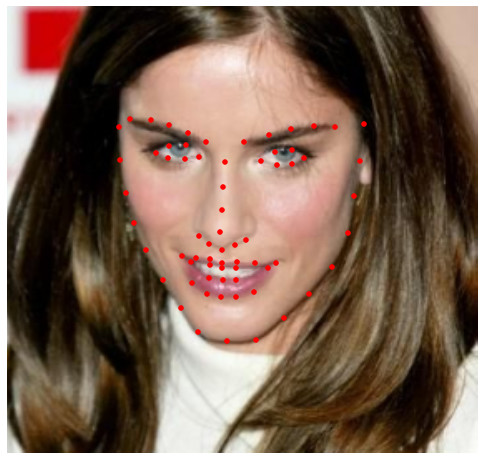

In [3]:
visualize_images(training_images)

## Load test data

In [4]:
test_images = []
for i in mio.import_images('/vol/atlas/databases/ibug/', 
                           verbose=True, max_images=None, normalise=None):    
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_66)
    test_images.append(i)

Importing assets: [==========] 100% (135/135) - 00:00:00 remaining


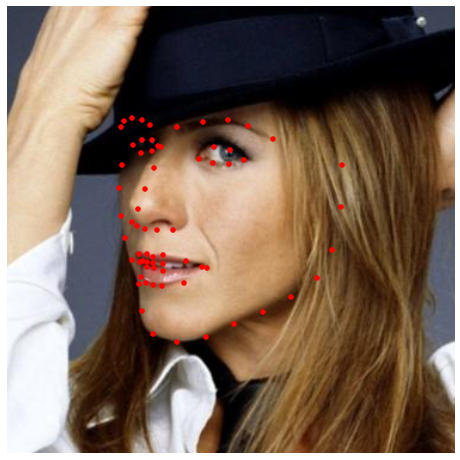

In [5]:
visualize_images(test_images)

## Train Supervised Fitter

In [6]:
sd_algorithm_cls = Newton
features = [sparse_hog, sparse_hog]
patch_shape = (17, 17)
diagonal = 100
scales = (1, .5)
iterations = 4
n_perturbations = 30

group = 'ibug_face_49'
verbose = True
l = 10000

In [7]:
sd_fitter_batch = SupervisedDescentFitter(
    sd_algorithm_cls=sd_algorithm_cls,
    features=features,
    patch_shape=patch_shape,
    diagonal=diagonal, 
    scales=scales,
    iterations=iterations,
    n_perturbations=n_perturbations)
    
sd_fitter_batch.train(   
    training_images,
    group=group,
    verbose=verbose,
    l=l)

KeyError: 'ibug_face_49'

In [ ]:
sd_fitter_incremental = SupervisedDescentFitter(
    sd_algorithm_cls=sd_algorithm_cls,
    features=features,
    patch_shape=patch_shape,
    diagonal=diagonal, 
    scales=scales,
    iterations=iterations,
    n_perturbations=n_perturbations)
    
sd_fitter_incremental.train_incrementally(    
    training_images,
    batch_size=300,
    group=group,
    verbose=verbose,
    l=l)

#### Fitting loop

In [ ]:
fitters = [sd_fitter_batch, sd_fitter_batch]

fitters_results = []

for j, i in enumerate(test_images):
    
    np.random.seed(j)
    gt_s = i.landmarks['ibug_face_66'].lms
    s = fitters[0].perturb_from_shape(gt_s, noise_std=0.05)

    for fitter in fitters:
        
        fr = fitter.fit(i, s, gt_shape=gt_s) 
        fr.downscale = 0.5
        fitters_results.append(fr)
    
        print 'Image: ', j
        print fr

## Results

In [ ]:
initial_errors = [fr.initial_error() for fr in fitters_results[::2]]

final_errors_1 = [fr.final_error() for fr in fitters_results[::2]]
final_errors_2 = [fr.final_error() for fr in fitters_results[1::2]]

In [ ]:
print 'ini:', np.mean(initial_errors), 'std_1:', np.std(initial_errors), 'median:', np.median(initial_errors) 
print 'mean_1:', np.mean(final_errors_1), 'std_1:', np.std(final_errors_1), 'median:', np.median(final_errors_1) 
print 'mean_2:', np.mean(final_errors_2), 'std_2:', np.std(final_errors_2), 'median:', np.median(final_errors_2) 

In [ ]:
errors = [initial_errors, final_errors_1, final_errors_2]

In [ ]:
plot_ced(errors, legend_entries=['ini', 'batch', 'incremental'])

In [ ]:
visualize_fitting_result(fitters_results[::2])

In [ ]:
visualize_fitting_result(fitters_results[1::2])

In [ ]:
%timeit -n 25 fr = sd_fitter_batch.fit(i, s, gt_shape=gt_s) 
%timeit -n 25 fr = sd_fitter_incremental.fit(i, s, gt_shape=gt_s) 

In [17]:
import line_profiler
import IPython

ip = IPython.get_ipython()
ip.define_magic('lprun', line_profiler.magic_lprun)

In [18]:
%lprun -f Newton.run fitter.fit(i, s, gt_shape=gt_s)